When you begin studying something complex, like modern deep learning framework, it is usually a good idea to begin with as simple example as possible, play with it, understand it well, and only then proceed to advanced stuff. So when a friend of mine who just started her first deep learning course approached me with questions about the basics of neural networks, I decided to show her a very simple example in PyTorch. I believed I can quickly find something relevant on the Web, but it appears that most of the tutorials, even beginner-level, start with MNIST, ConvNets, some specific PyTorch stuff like DataLoaders, etc. And I wanted something really-really simple. So, I wrote my own.

This post is available as jupyter notebook. You can open it in [Google Colab](https://colab.research.google.com/drive/1K7jitzE_3L3nmY0104XQlF4AHRQS9td3?usp=sharing) to edit and run the code.

## Install PyTorch

That's easy.

In [1]:
%pip install -U torch

Note: you may need to restart the kernel to use updated packages.


## Do some imports

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

torch.manual_seed(2)
np.random.seed(2)

%matplotlib inline
backend_inline.set_matplotlib_formats('svg')

Together with `torch`, we need `numpy` to work with arrays and `matplotlib.pyplot` to draw figures. I set random seeds to make everything reproducible. Magic command `%matplotlib inline` turns on inline mode: all the figures will be plotted inside of the notebook. I wanna nice SVG figures, so turn on it as a preferred format.

## Build neural network

Let's consider a very simple neural network.

In [3]:
def make_network(n_hidden):
    network = nn.Sequential(nn.Linear(1, n_hidden), 
                          nn.ReLU(), 
                          nn.Linear(n_hidden, 1))
    return network

Here we have a function that builds a network with given number of hidden layers (`n_hidden`). How is it constructed?

- `nn.Sequential` constructs a neural network as a sequence of layers, each layer performs transformation of the data, output of each layer is feeded to the input of the next layer.
- `nn.Linear(1, n_hidden)` is a linear (also known as _Dense_) layer with input dimension 1 and output dimension `n_hidden`.
- `nn.ReLU()` is just a ReLU activation function, applied elementwise. It does not change the dimension of the vector. Recall that $\mathop{\mathrm{ReLU}}(x)=\mathop{\mathrm{max}} (x, 0)$.
- `nn.Linear(n_hidden, 1)` is the second linear layer, this time input dimension is `n_hidden` and output dimension is 1.

Visually, our network looks like this (for `n_hidden = 5`):

![](torch101network1-5-1.svg)

Usually, when people discuss neural networks, each Linear layer is combined with the following ReLU layer and considered as one layer. I prefer to be a bit fine-grained here at this stage. Now let's use this function, create some network and play with it a little.

## Look inside the network

Neural networks are trained by adjusting their parameters according to the training data. In our simple case, only `Linear` layers have parameters, called _weights_ and _biases_. Mathematically speaking, each linear layer is a realization of an _affine_ map:

$$\tag{1}u=Wv+b,$$

where $v$ is input of the layer, $u$ is its output,  matrix $W$ and vector $b$ are parameters. Elements of $W$ are called _weights_ and elements of $b$ are called _biases_. Let's create a network and dig into the parameters of each layer.

In [4]:
network = make_network(n_hidden=5)

### First linear layer

In [5]:
linear1, relu, linear2 = network.children()
weights1, biases1 = linear1.parameters()
weights1

Parameter containing:
tensor([[ 0.2294],
        [-0.2380],
        [ 0.2742],
        [-0.0511],
        [ 0.4272]], requires_grad=True)

What's that `tensor` thing? Do not be afraid: it's just a PyTorch's name for an array. Here `weights` is a matrix $W$, in this case (as input is one-dimensional) it's a vector-column. Where these numbers came from? That's simple: they are random. Each time you create a neural network, its parameters are initialized by random numbers, unless you specify otherwise. That's why you can get different values when you run this code youself.

Let's look into `biases1`:

In [6]:
biases1

Parameter containing:
tensor([ 0.2381, -0.1149, -0.8085,  0.2283, -0.8853], requires_grad=True)

Here `biases1` is a vector (one-dimensional tensor) of length 5. So in this case equation (1) can be rewritten in the following way:

{{< math >}}
$$
\begin{pmatrix}
h_1 \\
h_2 \\
h_3 \\
h_4 \\
h_5
\end{pmatrix}
=
\begin{pmatrix}
w_{11} \\
w_{21} \\
w_{31} \\
w_{41} \\
w_{51}
\end{pmatrix} \cdot x +
\begin{pmatrix}
b_1 \\
b_2 \\
b_3 \\
b_4 \\
b_5
\end{pmatrix}
$$
{{< /math >}}

Here $(h_1, \ldots, h_n)$ (the same thing as $u$ in (1)) is an output of the first layer, $v$ (denoted by $x$ in (1)) is its input. Note that in this formula, vector of biases is presented as a matrix (vector-column), despite the fact that it is stored as a simple vector.

### ReLU

We do not expect that ReLU layer has any parameters (it's just elementwise application of ReLU function), but let's check it.

In [7]:
list(relu.parameters())

[]

Yupp. Empty list! No parameters. Exactly as expected.

### Second linear layer

In [8]:
weights2, biases2 = linear2.parameters()
weights2

Parameter containing:
tensor([[ 0.0588,  0.0297, -0.0983,  0.3657,  0.0298]], requires_grad=True)

In [9]:
biases2

Parameter containing:
tensor([0.1854], requires_grad=True)

See the difference? Now `weights2` is a vector-row and `biases2` is just one number (still stored as a vector of size 1). Why? That's because now input of the layer is 5-dimensional and output is 1-dimensional. Let's write down equation (1) for this case.

{{< math >}}
$$y = \begin{pmatrix}
w'_{11} & w'_{12} & w'_{13} & w'_{14} & w'_{15}
\end{pmatrix}
\cdot
\begin{pmatrix}
h'_1 \\
h'_2 \\
h'_3 \\
h'_4 \\
h'_5
\end{pmatrix}
+ b',
$$
{{< /math >}}

where $y$ is an output of the layer (and the whole network), $(h'_1, h'_2, h'_3, h'_4, h'_5)$ is its input.

We see that in this formula, vector-row of weights is multiplied by vector-column of inputs and the result is just one number. This is in perfect agreement with our network specification: we need one-dimensional output. That's why vector of biases is also of length 1.

I hope now it is clear how internals of the network works. Let's try to turn it on!

## Neural network as a function

Assume I want to put some number, say, $2.3$, as an input of my neural network, and get an output. How to do that?

In [10]:
network(torch.tensor([2.3]))

tensor([0.2739], grad_fn=<AddBackward0>)

Here we just invoked our `network` object as a function. Its input should be `torch.tensor`, not just a `float`, and it expects a vector, not a single number, so we put $2.3$ inside a square brackets to create a list and wrap it into `torch.tensor` to create a tensor. The result is again a tensor. It's easy, isn't it?

As it usually happens, sometimes (actually, almost every time) we need to apply a function not to a single value, but to a bunch of values. This is called _vectorization_ and it's how `numpy` works, and it allows us to avoid slow loops and keep everything fast even despite the fact we use rather slow Python language. Vectorization is at core of neural network frameworks as well, so our network can accept not only one input, but several inputs at once.

In [11]:
network(torch.tensor([[2.3], [1.7], [3.6]]))

tensor([[0.2739],
        [0.2741],
        [0.2661]], grad_fn=<AddmmBackward0>)

The output is again a tensor. Note that both input and output can be considered as vector rows, i.e. single input and output values are recorded as their rows.

Now let's draw some pictures!

## Visualize the output

As our network defines a map from numbers to numbers, I'd like to draw its graph. It can be done in the following way. First, we need to generate an array of values of network input (i.e. values of $x$) we are intersted in, i.e. some values on the segment, say, $[-3, 3]$. As we already discussed, it need to be put into vector-column, so the code looks like this:

In [12]:
x = np.linspace(-3, 3, 301, dtype="float32").reshape(-1, 1)

{{< spoiler text="What is `linspace`" >}}
Function `np.linspace(-3, 3, 301)` creates an array of 301 points, from -3 to 3, with equal distance between points. Here is an example:

In [13]:
np.linspace(-3, 3, 5)

array([-3. , -1.5,  0. ,  1.5,  3. ])

{{< /spoiler >}}
{{< spoiler text="What is `dtype='float32'`" >}}
numpy can use various data types to store numbers. PyTorch expects numbers to be stored in 32-bit floats, that's called `float32` in numpy. So we ask numpy to create an array of that type.
{{< /spoiler >}}
{{< spoiler text="What is `reshape`?" >}}
We need a vector-column, so we do `.reshape(-1, 1)`. This methods, as the name suggest, allows one to change a shape of a particular array. For example:

In [14]:
arr = np.array([1, 2, 3, 4, 5, 6])
arr.shape

(6,)

This is one-dimensional array (i.e. vector) of size 6.
We can reshape it to a matrix with 2 rows and 3 columns:

In [15]:
arr.reshape(2, 3)

array([[1, 2, 3],
       [4, 5, 6]])

In [16]:
arr.reshape(2, 3).shape

(2, 3)

And we can reshape it to a matrix with 3 rows and 2 columns:

In [17]:
arr.reshape(3, 2)

array([[1, 2],
       [3, 4],
       [5, 6]])

Of course, the number of elements in the matrix is the same as it was in the array, so if number of rows is specified, number of columns can be found automatically, and vice versa. Thus we can omit one of the numbers: this is done by replacing it with `-1`, in this case we simply ask Python to find this number by itself.

In [18]:
arr.reshape(3, -1)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [19]:
arr.reshape(-1, 2)

array([[1, 2],
       [3, 4],
       [5, 6]])

If we want a vector-column, we specify that we want one column, and allow Python to calculate how many rows it needs:

In [20]:
arr.reshape(-1, 1)

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]])

There are other ways to convert vector to vector-column, but we'll use `.reshape`.
{{< /spoiler >}}

In [21]:
y = network(torch.tensor(x)).detach().numpy()

To find the output of the network, we used the same syntax as previously (convert `x` to `torch.tensor` and feed into the `network` object). Then we need to convert the output tensor back to numpy array. PyTorch keep various information together with each tensor — basically, it remembers how this tensor was constructed, how it is related to other tensors. This allows PyTorch to find derivatives automatically. To convert a tensor to a numpy object, we first have to _detach_ it from the computational graph, this is done with `.detach()`, then apply `.numpy()` method, and we're done!

In [22]:
type(y)

numpy.ndarray

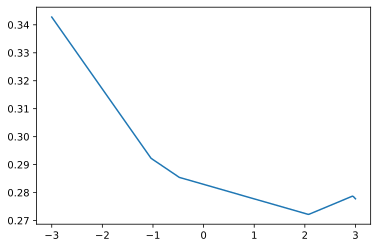

In [23]:
plt.plot(x, y)

{{< spoiler text="How `plt.plot` works?" >}}
`plt.plot` allows one to draw a line or points given their corresponding x and y coordinates.

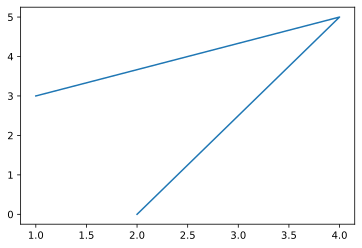

In [24]:
plt.plot([1, 4, 2], [3, 5, 0])

The first argument of `plt.plot` is an array of x-coordinates and the second is an array of y-coordinates. Here we are drawing a line through points (1, 3), (4, 5), (2, 0), connecting them with straight segments.
{{< /spoiler >}}

The result is picewise linear function, exactly as expected. Let's wrap our visualization code into the function to be able to reuse it.

In [25]:
def plot_network(network, xmin=-4, xmax=4, npoints=300):
    inputs = np.linspace(xmin, xmax, npoints, dtype="float32").reshape(-1, 1)
    outputs = network(torch.tensor(inputs)).detach().numpy()
    plt.plot(inputs, outputs)

Let's find how number of hidden neurons affects the graph.

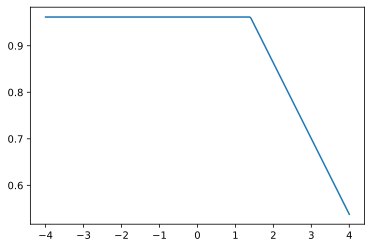

In [26]:
plot_network(make_network(1))

That's basically just a ReLU function with some shifts and rescaling that depends on the weights. (If you run this command several times, you'll see the the effect of weights.)

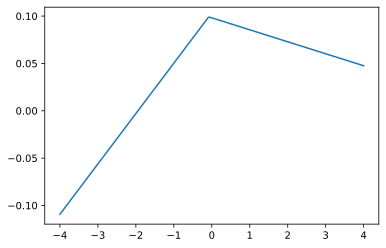

In [27]:
plot_network(make_network(2))

That's a sum of two ReLU's, again, each have some shifts and rescalings.

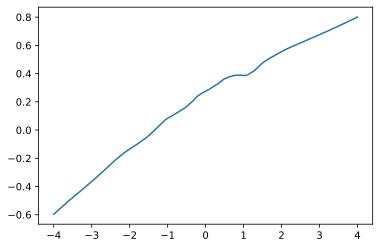

In [28]:
plot_network(make_network(1000))

If we increase number of neurons, the results looks more like a smooth curve. Note that despite the fact we have a sum of 1000 functions, the range of our function does not explode: that's because of the smart random initialization: the more neurons we have, the smaller random weights are assigned at the second linear layer.

Now it's time for the most interesting thing: training! But first we need some data to train on.

## Generate data

We will generate the training set using some well-known functions like $y=x^2$.

In [29]:
n_samples = 20
x_train = np.random.uniform(-3, 3, size=(n_samples, 1)).astype('float32')
y_train = x_train ** 2

Here `np.random.uniform` creates an array of random numbers from the segment $[-3, 3]$ with uniform distribution. The `size` parameter says that we need a vector-column (i.e. a matrix with `n_samples` rows and `1` column).

Note that all the arithmetic operations with `numpy`'s arrays are elementwise, so `y_train` is a matrix of the same size as `x_train` with all elements squared. Let's visualize it.

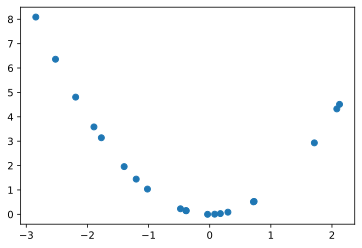

In [30]:
plt.plot(x_train, y_train, "o")

Looks good! Here we put `"o"` to get a scatter plot instead of a line.

## Setup the training loop

To train a neural network, we need four things:

1. The neural network.
2. Optimization criterion or loss. It is a function that measures the difference between the network's predictions and the data.
3. Optimizer. It is an algorithm that specifies how parameters are changed during the training.
4. The data to train on.

We already have the data. Let's define the rest.

In [31]:
network = make_network(n_hidden=10)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.001)

First we create a neural network using our `make_network` function. Then we define a criterion — in this case, we use popular mean squared error loss (sum of the squares of the differences between the network output and the correct values of y). Then we create an optimizer: here we choose simple gradient descent. (It's stochastic by name, but we'll use without any stochasticity.)

Now let's combine everything into the training loop. To make things more fun, we'll draw the graph of the network output during the training. (Animation doesn't show on the static page, you have to run [the notebook](https://colab.research.google.com/drive/1K7jitzE_3L3nmY0104XQlF4AHRQS9td3?usp=sharing) to see it.)

In [32]:
from IPython.display import clear_output, display

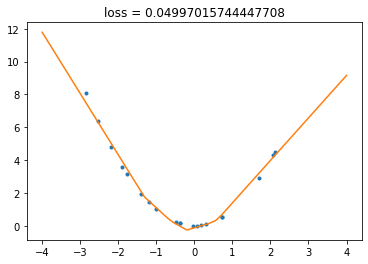

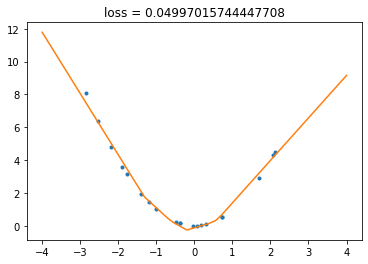

In [33]:
backend_inline.set_matplotlib_formats('png')
# animation works terribly slow with svg, so we fallback to png

training_steps = 10000
animate_each_step = 100

fig, ax = plt.subplots()
# created a figure and axes to draw on them

for i in range(training_steps):
    outputs = network(torch.tensor(x_train))
    # each time we find the output of our network
    
    loss = criterion(outputs, torch.tensor(y_train))
    # calculate the loss using our criterion
    
    # Some PyTorch Magic
    optimizer.zero_grad()
    # reset the gradients
    
    loss.backward()
    # at this step, we differentiate the loss 
    # and backpropagate its gradient through the network,
    # so we know how to change the parameters
    
    optimizer.step()
    # we change the parameters according to the gradients their recieved
    
    # End of Magic

    
    if i % animate_each_step == 0:
        clear_output(wait=True)
        plt.gca().clear()
        # clear the axes
        
        plt.plot(x_train, y_train, ".")
        plot_network(network, npoints=400)
        # plot everything
        
        plt.title(f"loss = {loss}")
        display(fig)

And that's it! You can run the previous cell severals times: the state of the network is kept between the runs, so you can make it better and better.

### It's play time!
Now you can play with the code. What happens if you change number of neurons? If you use only one neuron? Or two? (Try running this example several times. How do you thing, why sometimes it works so badly?) If you use a lot of neurons? Which number of neurons gives you best fit to the data? Which number of neurons allows the netork to recover the true dependence? What if you use different function, say $\sin(x)$, instead of $x^2$, to generate the training data? Can neural network extrapolate the function, i.e. give reasonable prediction outside of the domain it trained? What happens if you add some noise to the data during the data generation? What happens if you add more layers to the network? Which network learns faster: shallow or deep?

You can try to find answers to all these questions by tweaking the code above. So, go ahead!

### P.S.
A lot of topics are outside of the scope of this tutorial. We didn't discuss how gradient descent works, how to properly evaluate the quality of neural network using test sets and cross-validation, the notions of overfit and underfit and so on. I suggest taking some intro ML course that discuss these things in details before you dive into the depth of the deep learning.